<a href="https://colab.research.google.com/github/Lucas-Buk/Machine-Learning-Metodos-Prob/blob/main/Bundesliga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install arviz

In [ ]:
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats
import theano

from theano import tensor as T
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
from arviz import plot_trace

%matplotlib inline

In [ ]:
### Load the data to lookup team-id and corresponding team-name
url_vereine_csv = "https://github.com/hsro-wif-prg2/hsro-wif-prg2.github.io/raw/master/examples/src/main/resources/bundesliga_Verein.csv"
clubs = pd.read_csv(url_vereine_csv, sep=';')

### for convinience the club id should start with 0
clubs.V_ID = clubs.V_ID - 1
clubs = clubs.set_index("V_ID")

### just 1. league 
club_ids = clubs[clubs.Liga==1].index
club_ids

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], dtype='int64', name='V_ID')

In [ ]:
clubs.head()

,Name,Liga
V_ID,,
0,FC Bayern München,1
1,FC Schalke 04,1
2,Borussia Dortmund,1
3,RB Leipzig,1
4,Bayer Leverkusen,1


In [ ]:
### Now load the data about past games from 2017 and 2018
url_spiele_csv = "https://github.com/hsro-wif-prg2/hsro-wif-prg2.github.io/raw/master/examples/src/main/resources/bundesliga_Spiel.csv"
games = pd.read_csv(url_spiele_csv, sep=';')

#del(games["Unnamed: 8"]) ### not existent anymore?

### for convinience the club id should start with 0
games.Heim = games.Heim-1
games.Gast = games.Gast-1

games.head()

,Spiel_ID,Spieltag,Datum,Uhrzeit,Heim,Gast,Tore_Heim,Tore_Gast
0,1,1,2017-08-18,20:30:00,0,4,3,1
1,2,1,2017-08-19,15:30:00,6,11,1,0
2,3,1,2017-08-19,15:30:00,14,2,0,3
3,4,1,2017-08-19,15:30:00,10,7,2,0
4,5,1,2017-08-19,15:30:00,17,9,1,0


In [ ]:
### Filter for games of teams in 1st league
relevant_games = games[games.Heim.isin(club_ids)]

### Have a look at the data
relevant_games.sample(10)

,Spiel_ID,Spieltag,Datum,Uhrzeit,Heim,Gast,Tore_Heim,Tore_Gast
195,196,22,2018-02-10,18:30:00,0,1,2,1
98,99,11,2017-11-05,18:00:00,14,10,3,3
215,216,24,2018-02-26,20:30:00,2,9,1,1
630,1352,32,2018-04-27,20:30:00,6,12,3,1
27,28,4,2017-09-15,20:30:00,12,17,2,0
600,1004,30,2018-04-15,18:00:00,11,3,1,1
161,162,18,2018-01-14,18:00:00,2,14,0,0
63,64,8,2017-10-13,20:30:00,7,16,2,1
138,139,16,2017-12-12,20:30:00,17,5,1,2
199,200,23,2018-02-17,15:30:00,14,0,1,2


In [ ]:
### We'll use the games from 2017 for training the model
actual_date = "2018-01-01"
relevant_games = relevant_games[games.Datum < actual_date]
print('Size of training set: ', len(relevant_games))

Size of training set:  153


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
### We are not interested in date and time data,
### so we extract only team ids and score:

def get_goal_results(gh="Tore_Gast"):
    result = list()
    for i in relevant_games.iterrows():
        ### index 0 contains pandas-dataframe id, 
        ### which we are not interested in.
        r = i[1]
        result.append((r.Heim, r.Gast, r[gh]))
    return result

### Lists of tuples
away_goals_ = get_goal_results("Tore_Gast")
home_goals_ = get_goal_results("Tore_Heim")

### Print one example
print('First tuple of list \'away_goals_\':')
print('(id_home, id_guest, goals_guest)')
print(away_goals_[0])

print('\nFirst tuple of list \'home_goals_\':')
print('(id_home, id_guest, goals_home)')
print(home_goals_[0])

First tuple of list 'away_goals_':
(id_home, id_guest, goals_guest)
(0, 4, 1)

First tuple of list 'home_goals_':
(id_home, id_guest, goals_home)
(0, 4, 3)


In [ ]:
### Number of clubs
nb_clubs = len(club_ids)

### offence-defence could be negative, but number of goals scored cannot.
### When dealing with distributions for continous variables, 
### e.g. gaussian (normal), theres never probability of exactly 0,
### so for zero we'll use something very small instead
low = 1e-10

In [ ]:
model = pm.Model()

with model:
    offence = pm.Normal("offence", tau=1., mu=1.5, shape=nb_clubs)
    defence = pm.Normal("defence", tau=1., mu=0., shape=nb_clubs)

    home_goals = []
    home_values = []

    ### iterate through goals scored at home
    for i,(heim, gast, goals) in enumerate(home_goals_):
        home_value = offence[heim]-defence[gast]

        ### no negative home value
        home_value = T.switch(T.lt(home_value, 0.), low, home_value) 
        home_values.append(home_value)
        home_goals.append(goals)
        
    home_values_ = T.stack(home_values)
    mu_home = pm.Deterministic("home_rate", home_values_)
    pm.Poisson("home_goals", observed=home_goals, mu=mu_home)

    away_goals = []
    away_values = []

    for i,(heim, gast, goals) in enumerate(away_goals_):
        away_value = offence[gast]-defence[heim]

        ### no negative home value
        away_value = T.switch(T.lt(away_value, 0.), low, away_value) 
        away_values.append(away_value)
        away_goals.append(goals)
        
    away_values_ = T.stack(away_values)
    mu_away = pm.Deterministic("away_rate", away_values_)
    pm.Poisson("away_goals", observed=away_goals, mu=mu_away)

In [ ]:
### number of samples
nb_samples=1000

### tune adds additional number of samples.
### after sampling these additional samples get discarded
### as the very first samples are very inaccurate
tune = nb_samples//10

with model:
    trace = pm.sample(draws=nb_samples, tune=tune) 

In [ ]:
### mean of offence strength
print('Mean offence strenght per team:')
for i in club_ids: 
    print(clubs[clubs.index==i]["Name"][i], " ", trace.get_values("offence")[:,i].mean())

Mean offence strenght per team:
FC Bayern München   2.1046556102373324
FC Schalke 04   1.701280248927213
Borussia Dortmund   2.263965802505241
RB Leipzig   1.6064518179075775
Bayer Leverkusen   2.007487377909153
Eintracht Frankfurt   1.2891177378744696
1899 Hoffenheim   1.717242498968648
VfB Stuttgart   0.8453029623921662
Borussia Mönchengladbach   1.7602329124323992
FC Augsburg   1.6413262508240951
Hertha BSC   1.706969553820606
SV Werder Bremen   0.899525971525647
Hannover 96   1.5783508448170136
SC Freiburg   1.0572592895548965
VfL Wolfsburg   1.4823759489136628
1. FSV Mainz 05   1.2665441168955107
1. FC Köln   0.7465646800781142
Hamburger SV   0.9929242319627526


In [ ]:
### mean of defence strength
print('Mean defence strenght per team:')
for i in club_ids: 
    print(clubs[clubs.index==i]["Name"][i], " ", trace.get_values("defence")[:,i].mean())

Mean defence strenght per team:
FC Bayern München   0.7884059155340868
FC Schalke 04   0.055088027523105536
Borussia Dortmund   -0.0672964248085942
RB Leipzig   -0.023997730093844878
Bayer Leverkusen   0.06654473691363703
Eintracht Frankfurt   0.23255564933118325
1899 Hoffenheim   0.004035995854081966
VfB Stuttgart   0.03995457334157044
Borussia Mönchengladbach   -0.06208372195523613
FC Augsburg   0.05870940745030102
Hertha BSC   -0.05253851799627355
SV Werder Bremen   0.290150680170841
Hannover 96   -0.15712736129538668
SC Freiburg   -0.4264468553006201
VfL Wolfsburg   0.0807648672483114
1. FSV Mainz 05   -0.2604933442298362
1. FC Köln   -0.4556956562401515
Hamburger SV   -0.050274165194306254


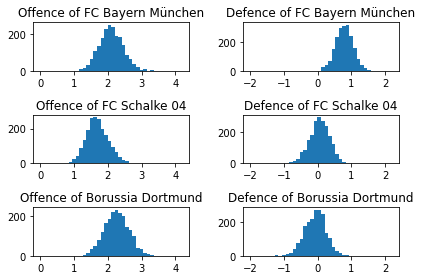

In [ ]:
nb_clubs = club_ids.max() + 1
club_ids_to_show = [0,1,2]
bins = 40
fig, axes = plt.subplots(nrows=len(club_ids_to_show), ncols=2)

for i in club_ids_to_show: 
    title = "Offence of " + clubs[clubs.index==i]["Name"][i]
    axes[i, 0].set_title(title)
    axes[i, 0].hist(trace.get_values("offence")[:,i], bins=bins, range=(0,4.2))
    
    axes[i, 1].hist(trace.get_values("defence")[:,i], bins=bins, range=(-2.,2.2))
    title = "Defence of " + clubs[clubs.index==i]["Name"][i]
    axes[i, 1].set_title(title)

#fig.suptitle("Offence and defence distribution of the clubs.")
fig.subplots_adjust(hspace=0.5)
fig.tight_layout()

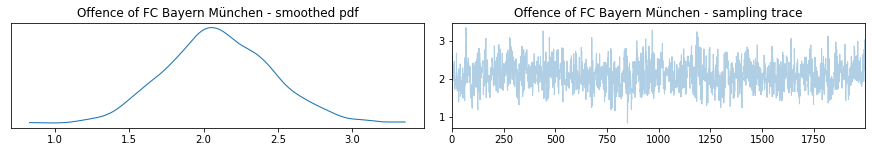

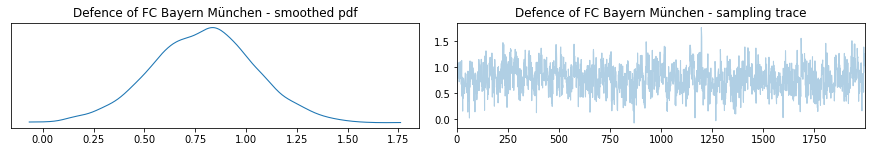

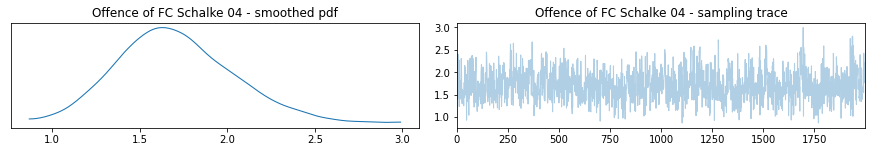

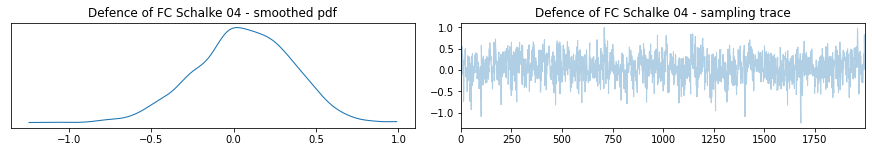

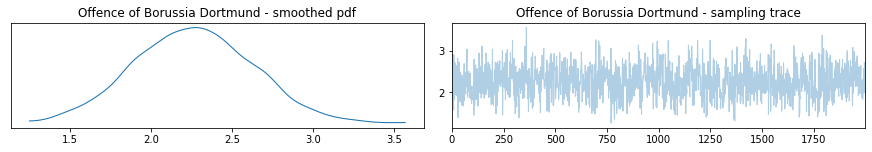

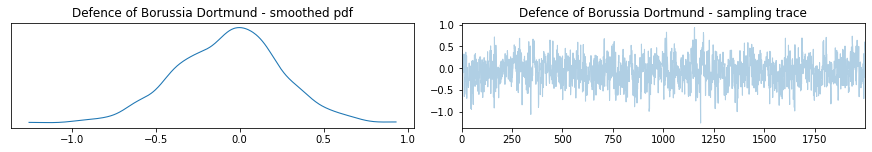

In [ ]:
for i in club_ids_to_show: 
    title = "Offence of " + clubs[clubs.index==i]["Name"][i]
    ax = plot_trace(trace.get_values("offence")[:,i])
    ax[0,0].set_title(title + ' - smoothed pdf')
    ax[0,1].set_title(title + ' - sampling trace')
    title = "Defence of " + clubs[clubs.index==i]["Name"][i]
    ax = plot_trace(trace.get_values('defence')[:,i])
    ax[0,0].set_title(title + ' - smoothed pdf')
    ax[0,1].set_title(title + ' - sampling trace')

In [ ]:
def get_probs_winner(team_i, team_j):
  v1 = v2 = emp = tot = 0
  diff_ij = abs(trace.get_values("offence")[:,team_i] - trace.get_values("defence")[:,team_j])
  diff_ji = abs(trace.get_values("offence")[:,team_j] - trace.get_values("defence")[:,team_i])
  
  gols_casa = np.random.poisson(lam=diff_ij)
  gols_fora = np.random.poisson(lam=diff_ji)

  for i, v in enumerate(gols_casa):
    if gols_casa[i] > gols_fora[i]:
      v1 += 1
    elif gols_casa[i] < gols_fora[i]:
      v2 += 1
    else:
      emp += 1

    tot += 1


  print(clubs.at[team_i, "Name"],":",clubs.at[team_j, "Name"])
  p1 = v1/tot
  p2 = v2/tot
  tie = emp/tot
    
  print('(prob team1, prob team2, tie)')
  return p1, p2, tie


In [ ]:
get_probs_winner(0, 17)

FC Bayern München : Hamburger SV
(prob team1, prob team2, tie)


(0.8095, 0.0445, 0.146)